In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.color import rgb2hsv, rgb2gray
from utils import load_input_image
from segmentation import Segmentation
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.stats import kurtosis, skew
import sklearn


In [3]:
def color_features(img):
    median = np.median(img, axis=(0, 1))
    std = np.std(img, axis=(0, 1))
    mean = np.mean(img, axis=(0, 1))
    kurtosis_c = kurtosis(img, axis=(0, 1))
    skew_c = skew(img, axis=(0, 1))
    img_hsv = rgb2hsv(img)
    median_hsv = np.median(img_hsv, axis=(0, 1))
    std_hsv = np.std(img_hsv, axis=(0, 1))
    mean_hsv = np.mean(img_hsv, axis=(0, 1))
    kurtosis_hsv = kurtosis(img_hsv, axis=(0, 1))
    skew_hsv = skew(img_hsv, axis=(0, 1))

    return np.hstack(
        [
            median,
            std,
            mean,
            kurtosis_c,
            skew_c,
            median_hsv,
            std_hsv,
            mean_hsv,
            kurtosis_hsv,
            skew_hsv,
        ]
    )

In [4]:
def fourier_features(img):
    transform = np.fft.fft2(rgb2gray(img))
    ft = np.log(np.abs(np.fft.fftshift(transform)))[1:, 1:]  # [51:-50, 51:-50]

    ft_median = np.median(ft)
    ft_mean = np.mean(ft)
    ft_std = np.std(ft)
    ft_kurtosis = kurtosis(ft, axis=(0, 1))
    ft_skew = skew(ft, axis=(0, 1))

    binary_ft = ft > 4.5
    non_zero = np.count_nonzero(binary_ft)
    v = np.stack(np.where(binary_ft), axis=1)
    cov = np.cov(v.T)
    eigval, eigvec = np.linalg.eig(cov)

    idx = np.argsort(eigval)
    eigval, eigvec = eigval[idx], eigvec[idx]

    angle = np.arctan2(eigvec[0][1], eigvec[0][0]) % (np.pi / 2)

    k, l = np.indices((127, 127)) - 63
    m_00 = np.sum(ft)
    m_20 = np.sum(k**2 * ft)
    m_02 = np.sum(l**2 * ft)
    M1 = m_02 + m_20

    return np.hstack(
        [
            ft_median,
            ft_mean,
            ft_std,
            ft_kurtosis,
            ft_skew,
            non_zero,
            eigval,
            angle,
            M1 / m_00,
        ]
    )

In [5]:
def get_features(img):
    # COLOR
    color = color_features(img)

    # FOURIER
    fourier = fourier_features(img)

    # EDGES
    canny_img = cv2.Canny(img, 50, 200)
    num_edges = np.count_nonzero(canny_img)

    return np.hstack(
        [
            color,
            fourier,
            num_edges,
        ]
    )

In [6]:
def correlate(img1, img2):
    return (
        np.sum((img1 - np.mean(img1)) * (img2 - np.mean(img2))) / (np.std(img1) * np.std(img2) * np.size(img1))
    )

In [7]:
def get_correlation(pieces):
    crop_imgs = []
    distances = []

    for img in pieces:
        transform = np.fft.fft2(rgb2gray(img))
        fshift = np.fft.fftshift(transform)
        crop_img = np.log(np.abs(fshift[51:-50, 51:-50]))
        crop_imgs.append(crop_img)

    for img in crop_imgs:
        arr = np.array(
            [
                max(correlate(b,img), correlate(np.rot90(b),img))
                for b in crop_imgs
            ]
        )
        distances.append(arr)

    distances = np.array(distances)
    normalized_distances = normalize(distances, axis=0)

    return normalized_distances

In [8]:
def get_distances(pieces):
    crop_imgs = []
    distances = []

    for img in pieces:
        transform = np.fft.fft2(rgb2gray(img))
        fshift = np.fft.fftshift(transform)
        crop_img = np.log(np.abs(fshift[51:-50, 51:-50]))
        crop_imgs.append(crop_img)

    for img in crop_imgs:
        arr = np.array(
            [
                min(np.sum((b - img) ** 2), np.sum((np.rot90(b) - img) ** 2))
                for b in crop_imgs
            ]
        )
        distances.append(arr)


    distances = np.array(distances)
    normalized_distances = normalize(distances, axis=0)

    return normalized_distances

In [9]:
imgs = {i: load_input_image(i,folder="train2") for i in range(12)}

In [10]:
sorted_pieces = [
    [[0,2,8,9,10,12,13,14,19], [1,5,6,11,16,21,22,25,26], [3,4,7,15,17,18,20,24]    ,[23]], 
    [[2,4,7,8,10,11,12,13,14], [0,1,5,6,9,15,16,17,19]  , []                        ,[3,18,20]],
    [[2,5,6,17,19,20,22,23,24],[1,4,9,13,15,18,21,25,26], [3,7,8,10,11,12,14,16,27] ,[0]],
    [[0,1,2,5,11,12,13,16,17], [3,4,6,7,8,9,15,18,20]   , []                        ,[10,14,19]],
    [[1,3,5,7,8,9,11,15,18]  , [2,4,6,10,12,13,14,17,19], []                        ,[0,16]],
    [[3,4,6,7,9,10,15,19,24],  [0,8,12,14,16,17,18,20,26],[1,2,5,11,13,21,22,23,27] ,[25]],
    [[0,2,5,8,10,18,25,26,27], [1,3,4,12,14,15,17,21,23], [6,7,9,11,16,19,22,24,28] ,[13, 20]],
    [[0,1,7,9,12,14,19,23,27], [2,4,5,13,18,22,24,25,26], [3,8,10,11,15,16,17,20,21],[6]],
    [[0,1,2,5,6,8,11,12,14,15,16,18,20,21,23,26],[3,4,7,9,10,13,19,22,25],[]        ,[17,24]],
    [[0,2,4,5,6,13,17,23,25],  [1,9,10,12,14,15,16,19,22],[7,8,18,20,21,24,26,27,28],[3,11]],
    [[0,1,8,12,14,17,18,20,22],[2,3,4,9,10,15,16,21,23] , [5,6,7,11,13,19,25,26,27] ,[24]],
    [[1,2,5,6,9,11,14,15,18],  [3,4,7,8,10,12,13,16,17],  []                        ,[0]]
]

In [11]:
MAX_OUTLIERS = 4
NUM_PIECES_INVERSE = [16, 12, 9]
NUM_CLUSTER_INVERSE = [4, 3, 2]


def valid_labels(counts):
    num_outliers_clusters = np.count_nonzero(counts<MAX_OUTLIERS)
    if (
        (MAX_OUTLIERS < counts) & (counts < min(NUM_PIECES_INVERSE))
    ).any() or num_outliers_clusters > 1:
        return False
    return True

def count_outliers(count_label):
    for num_pieces in NUM_PIECES_INVERSE:
        if count_label - num_pieces >= 0:
            return count_label - num_pieces
    return 0  # outlier cluster


def classify_simple(features_PCA):
    for i in NUM_CLUSTER_INVERSE:
        gm = GaussianMixture(n_components=i, n_init=10, init_params="k-means++")
        labels = gm.fit_predict(features_PCA.copy())
        counts, _ = np.histogram(labels, bins=len(np.unique(labels)))
        if valid_labels(counts):
            for label in np.unique(labels):
                cluster_samples = features_PCA[labels == label]
                if len(cluster_samples) not in NUM_PIECES_INVERSE:
                    num_outliers = count_outliers(counts[label])
                    proba = gm.score_samples(cluster_samples)
                    outliers_index = np.argsort(proba)[:num_outliers]
                    new_labels = label * np.ones(len(cluster_samples))
                    new_labels[outliers_index] = -1
                    labels[labels == label] = new_labels

            return labels

In [12]:
#"""Jennifer don't run this or your PC will explose"""
colors = ["r", "g", "b", "k", "c", "m"]
orientation = [(30, 30), (90, 90), (0, 0), (0, 90)]
for index_img,img in imgs.items():
    seg = Segmentation(img)
    seg.find_pieces()
    features = np.array([get_features(seg.pieces[i]) for i in range(len(seg.pieces))])
    distances = get_distances(seg.pieces)
    correlation = get_correlation(seg.pieces)
    features = np.hstack([features, distances, correlation])
    features = (features - np.mean(features, axis=0)) / np.maximum(1e-10, np.std(features, axis=0))
    pca = KernelPCA(n_components=3,kernel="rbf")
    features_PCA = pca.fit_transform(features)
    indexes = sorted_pieces[index_img]

    labels = classify_simple(features_PCA)
    calinski_harabasz_score = sklearn.metrics.calinski_harabasz_score(
            features_PCA, labels
        )

    print(index_img,calinski_harabasz_score)
    

0 171.51797415373068  
1 31.34172883722475   
2 54.65372229497282   
3 25.998765922723933  
4 43.56446804916293   


KeyboardInterrupt: 

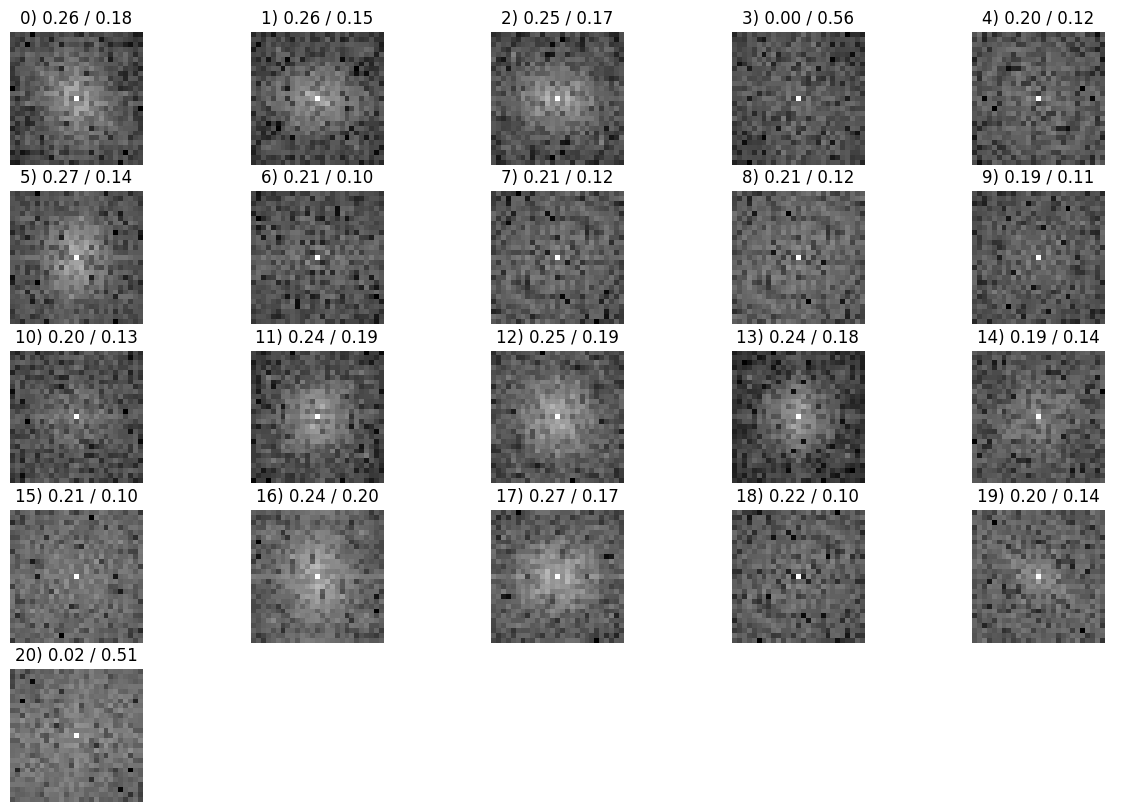

In [25]:
fig, axes = plt.subplots((len(seg.pieces)-1)// 5+1 , 5, figsize=(15, 10))

reference = 3
distances = get_distances(seg.pieces)
correlations = get_correlation(seg.pieces)
bouts_d_image = []

for i, (img, ax, d) in enumerate(zip(seg.pieces, axes.ravel(), distances)):
    transform = np.fft.fft2(rgb2gray(img))
    fshift = np.fft.fftshift(transform)
    bout_d_image = np.log(np.abs(fshift[51:-50, 51:-50]))
    bouts_d_image.append(bout_d_image) 
    
    ax.imshow(bout_d_image, cmap="gray")
    ax.axis("off")
    ax.set_title(f'{i}) {distances[i][reference]:<.2f} / {correlations[i][reference]:<.2f}')
    
for ax in axes.ravel()[len(seg.pieces):]:
    ax.axis("off")
plt.show()

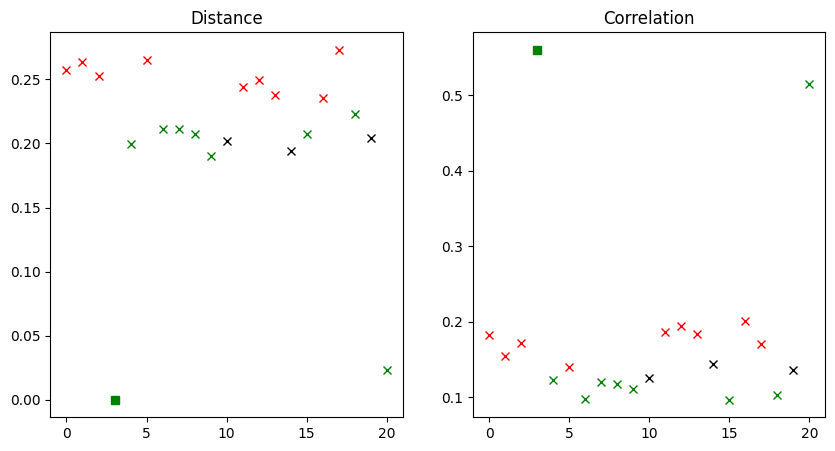

In [26]:
indexes = sorted_pieces[index_img]
colors = ["r", "g", "b", "k", "c", "m"]

dists_to_ref = np.array([distances[i][reference] for i in range(len(distances))])
corr_to_ref = np.array([correlations[i][reference] for i in range(len(distances))])

_,(ax1,ax2)= plt.subplots(1,2, figsize=(10,5))
for j, index in enumerate(indexes):
    if reference in index:
        ax1.plot(reference, dists_to_ref[reference], c=colors[j], marker='s')
        ax2.plot(reference, corr_to_ref[reference], c=colors[j], marker='s')
    ax1.plot(index, dists_to_ref[index].T, c=colors[j], marker="x", linestyle='none')
    ax2.plot(index, corr_to_ref[index].T, c=colors[j], marker="x", linestyle='none')
ax1.set_title("Distance")
ax2.set_title("Correlation")
plt.show()

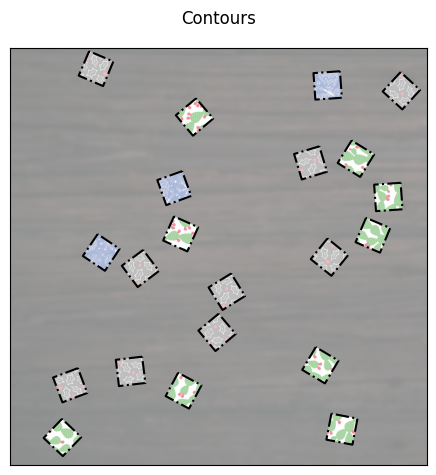

In [18]:
index_img = 3
img = imgs[index_img]
seg = Segmentation(img)
seg.find_pieces()
seg.plot_contours()

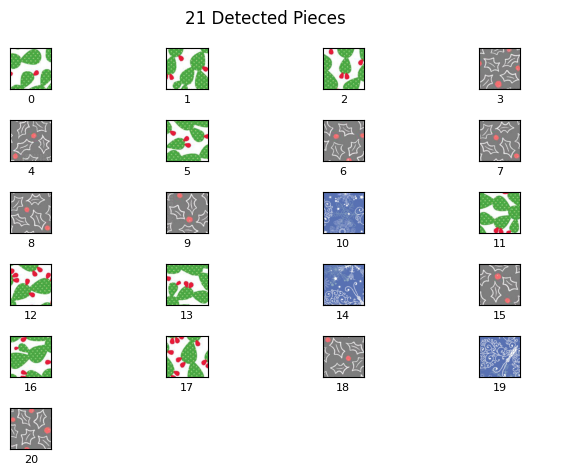

In [19]:
seg.plot_pieces()

In [21]:
features = np.array([get_features(seg.pieces[i]) for i in range(len(seg.pieces))])
distances = get_distances(seg.pieces)
correlation = get_correlation(seg.pieces)
features = np.hstack([features, distances, correlation])
features = (features - np.mean(features, axis=0)) / np.maximum(1e-10, np.std(features, axis=0))
features.shape

(21, 83)

In [22]:
pca = KernelPCA(n_components=3,kernel="rbf")
features_PCA = pca.fit_transform(features)

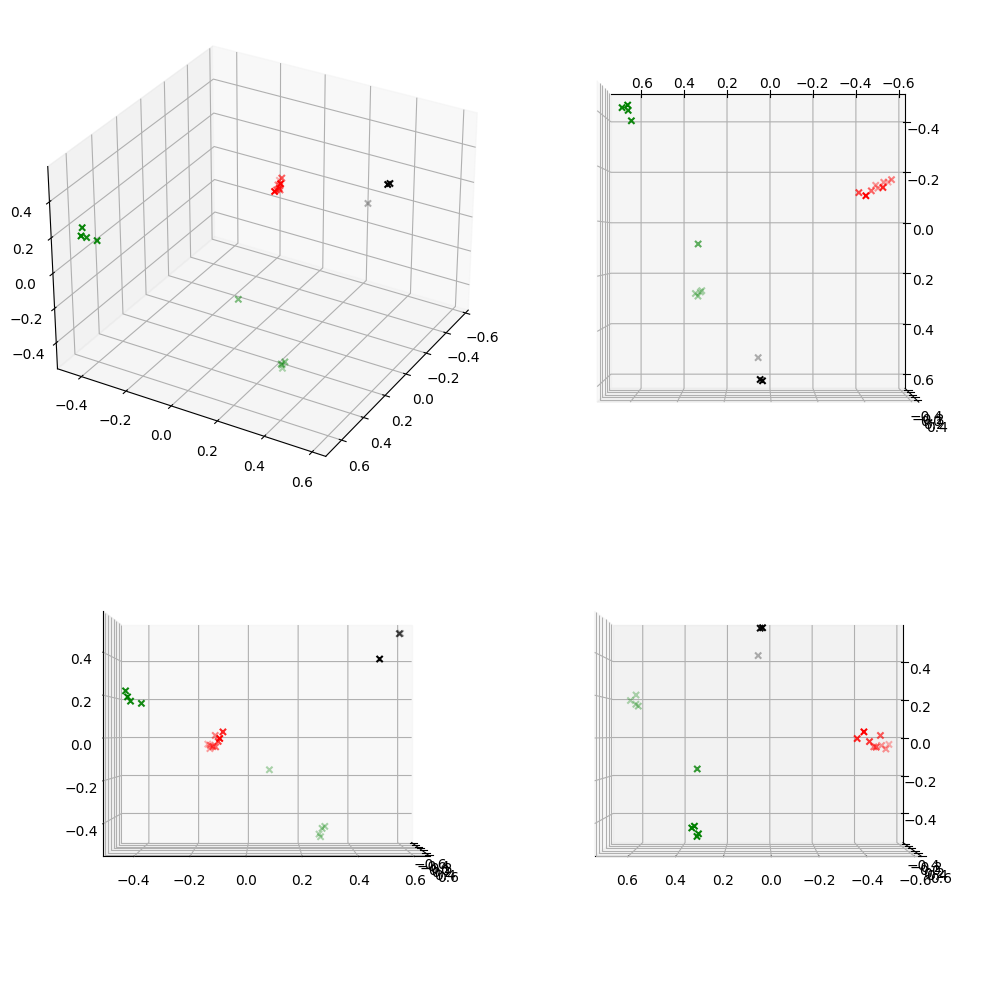

In [23]:
indexes = sorted_pieces[index_img]

colors = ["r", "g", "b", "k", "c", "m"]
orientation = [(30, 30), (90, 90), (0, 0), (0, 90)]

fig = plt.figure(figsize=(10, 10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    for j, index in enumerate(indexes):
        ax.scatter(*features_PCA[index].T, c=colors[j], marker="x")
        ax.view_init(elev=o[0], azim=o[1])
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))

for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x', label=label)
        ax.view_init(elev=o[0], azim=o[1])
    ax.legend()

plt.tight_layout()
plt.show()

In [49]:
def classify(features_PCA):
    n_pieces = [16, 12, 9]
    
    gm = [None]*2
    labels = [None]*2
    aic_values = []

    for i in range(2):
        gm[i] = GaussianMixture(n_components=i+2, n_init=10, init_params='k-means++')
        labels[i] = gm[i].fit_predict(features_PCA)
        

        features_filtered = features_PCA.copy()
        
        for label in np.unique(labels[i]):
            current_label_mask = labels[i] == label
            cluster_samples = features_PCA[current_label_mask]
            num_pieces = len(cluster_samples)

            for n in n_pieces:
                valid_samples_mask = np.ones(len(features_PCA), dtype=bool)

                if (n == 9 and 9 < num_pieces <= 12) or (n == 12 and 12 < num_pieces <= 16) or (n == 16 and num_pieces > 16):
                    centroid = gm[i].means_[label]
                    distances = np.sqrt(np.sum((cluster_samples - centroid) ** 2, axis=1))
                    distances_sorted = np.sort(distances)
                    threshold = distances_sorted[n-1]
                    outlier_mask = distances > threshold
                    outlier_samples_mask = outlier_mask
                    valid_samples_mask[current_label_mask] &= ~outlier_samples_mask


                labels_filtered = labels[i].copy()
                labels_filtered[~valid_samples_mask] = -1 
                features_filtered = features_PCA[valid_samples_mask]

                num_pieces_filtered = []
                for label_check in np.unique(labels[i]):
                    num_pieces_filtered.append(np.count_nonzero(labels_filtered == label_check))
                
                if all(num in n_pieces for num in num_pieces_filtered):
                    if len(features_filtered) >= i+2:  
                        gm[i].fit(features_filtered)
                        aic_value = gm[i].bic(features_filtered)
                        aic_values.append((aic_value, labels_filtered))
                        print(f'Model: {i+2}, Pieces: {n}, Label: {label}, AIC: {aic_value}')
                    else:
                        print(f'Model: {i+2}, Pieces: {n}, Label: {label}, AIC: Not enough samples')
    aic_values_only = np.array([x[0] for x in aic_values])
    print(aic_values_only)
    aic_min_index = np.argmin(aic_values_only)
    filtered_labels = aic_values[aic_min_index][1]

    return filtered_labels


Model: 2, Pieces: 16, Label: 1, AIC: -127.84226386016044
Model: 3, Pieces: 9, Label: 2, AIC: -185.3300312925613
[-127.84226386 -185.33003129]


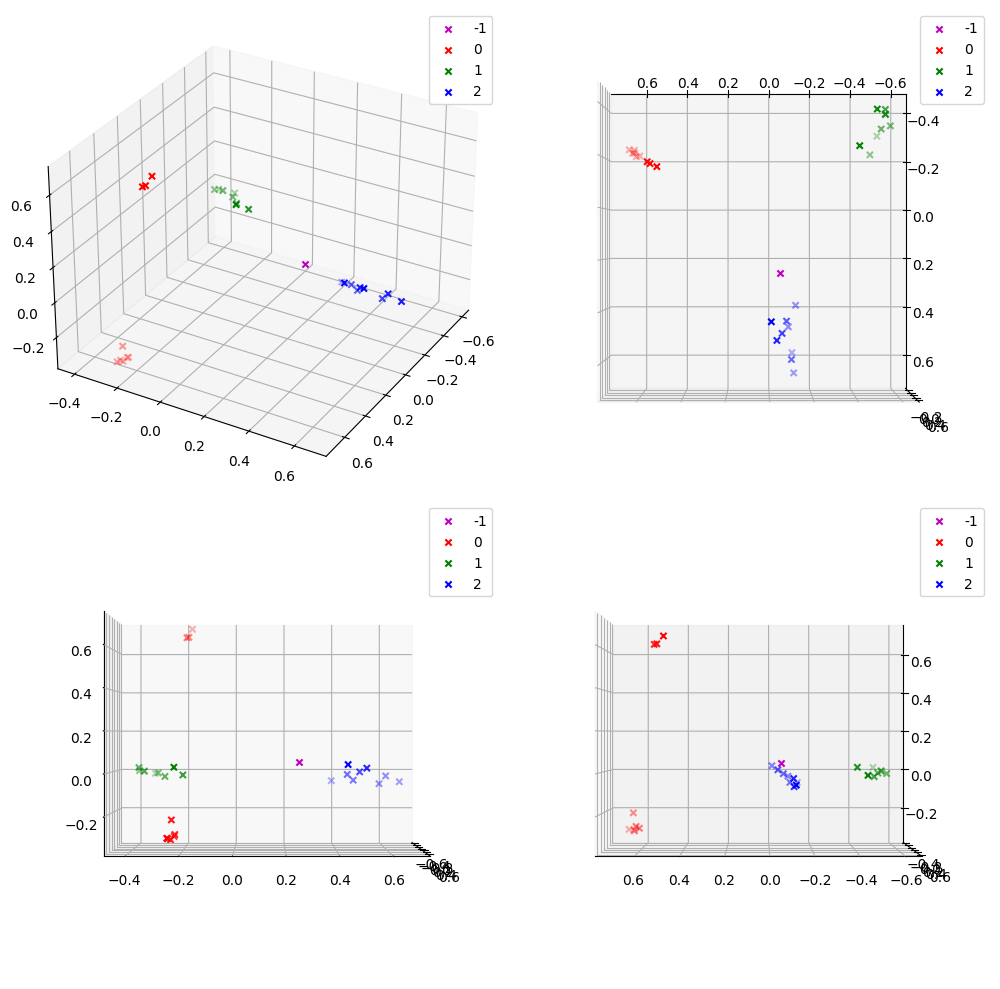

In [20]:
labels = classify(features_PCA)

fig = plt.figure(figsize=(10,10))

for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x', label=label)
        ax.view_init(elev=o[0], azim=o[1])
    ax.legend()

plt.tight_layout()
plt.show()

In [21]:
NUM_PIECES = [16, 12, 9]
NUM_PUZZLES = [2, 3]
MAX_OUTLIERS = 4


def classify_2(features_PCA):
    max_calinski_harabasz_score = 0
    for i in NUM_PUZZLES:

        def gmm():
            gm = GaussianMixture(n_components=i, n_init=10, init_params='k-means++')
            labels = gm.fit_predict(features_PCA)

            for label in np.unique(labels):
                cluster_samples = features_PCA[labels == label]
                cluster_num_pieces = len(cluster_samples)
                if (
                    cluster_num_pieces < min(NUM_PIECES)
                    or cluster_num_pieces - max(NUM_PIECES) > MAX_OUTLIERS
                ):
                    return None

                possible_num_pieces = []
                for n in NUM_PIECES:
                    if (
                        cluster_num_pieces >= n
                        and cluster_num_pieces - n <= MAX_OUTLIERS
                    ):
                        possible_num_pieces.append((n, cluster_num_pieces - n))
                        # par exemple (9,2) 9 pieces, 2 outliers

                if len(possible_num_pieces) >= 2:
                    gm_test = GaussianMixture(n_components=2, n_init=10)
                    labels_test = gm_test.fit_predict(cluster_samples)
                    num_c0 = list(labels_test).count(0)
                    num_c1 = list(labels_test).count(1)
                    if (
                        max(num_c0, num_c1),
                        min(num_c0, num_c1),
                    ) in possible_num_pieces:
                        num_outliers = min(num_c0, num_c1)
                    else:
                        if possible_num_pieces[1] == 0:
                            num_outliers = 0
                        else:
                            return None

                else:
                    num_outliers = possible_num_pieces[0][1]

                print(cluster_num_pieces-num_outliers, num_outliers)
                if num_outliers != 0:
                    centroid = gm.means_[label]
                    distances = np.sqrt(
                        np.sum((cluster_samples - centroid) ** 2, axis=1)
                    )
                    outliers_index = np.argsort(distances)[-num_outliers:]
                    new_labels = label * np.ones(cluster_num_pieces)
                    new_labels[outliers_index] = -1
                    labels[labels == label] = new_labels
            if np.count_nonzero(labels == -1) > MAX_OUTLIERS:
                return None
            return labels

        labels = gmm()
        calinski_harabasz_score = sklearn.metrics.calinski_harabasz_score(
            features_PCA, labels
        )
        print(
            "Possible classification\n"
            f"Number of pieces clusters: {np.unique(labels[labels!=-1])}","\n"
            f"Number of outliers: {np.count_nonzero(labels==-1)}","\n"
            f"Calinski Harabasz Score: {calinski_harabasz_score}","\n"
        )
        if np.any(labels) and calinski_harabasz_score > max_calinski_harabasz_score:
            best_labels = labels
            max_calinski_harabasz_score = calinski_harabasz_score
    print(
        f"Best classification\n"
        f"Number of pieces clusters: {np.unique(best_labels[labels!=-1])}","\n"
        f"Number of outliers: {np.count_nonzero(best_labels==-1)}","\n"
        f"Calinski Harabasz Score: {max_calinski_harabasz_score}","\n"
    )

    return best_labels

In [33]:
labels2 = classify_2(features_PCA)


16 3
9 0
Possible classification
Number of pieces clusters: [0 1] 
Number of outliers: 3 
Calinski Harabasz Score: 11.876140013027918 

9 0
9 0
9 1
Possible classification
Number of pieces clusters: [0 1 2] 
Number of outliers: 1 
Calinski Harabasz Score: 40.203322299970665 

Best classification
Number of pieces clusters: [0 1 2] 
Number of outliers: 1 
Calinski Harabasz Score: 40.203322299970665 



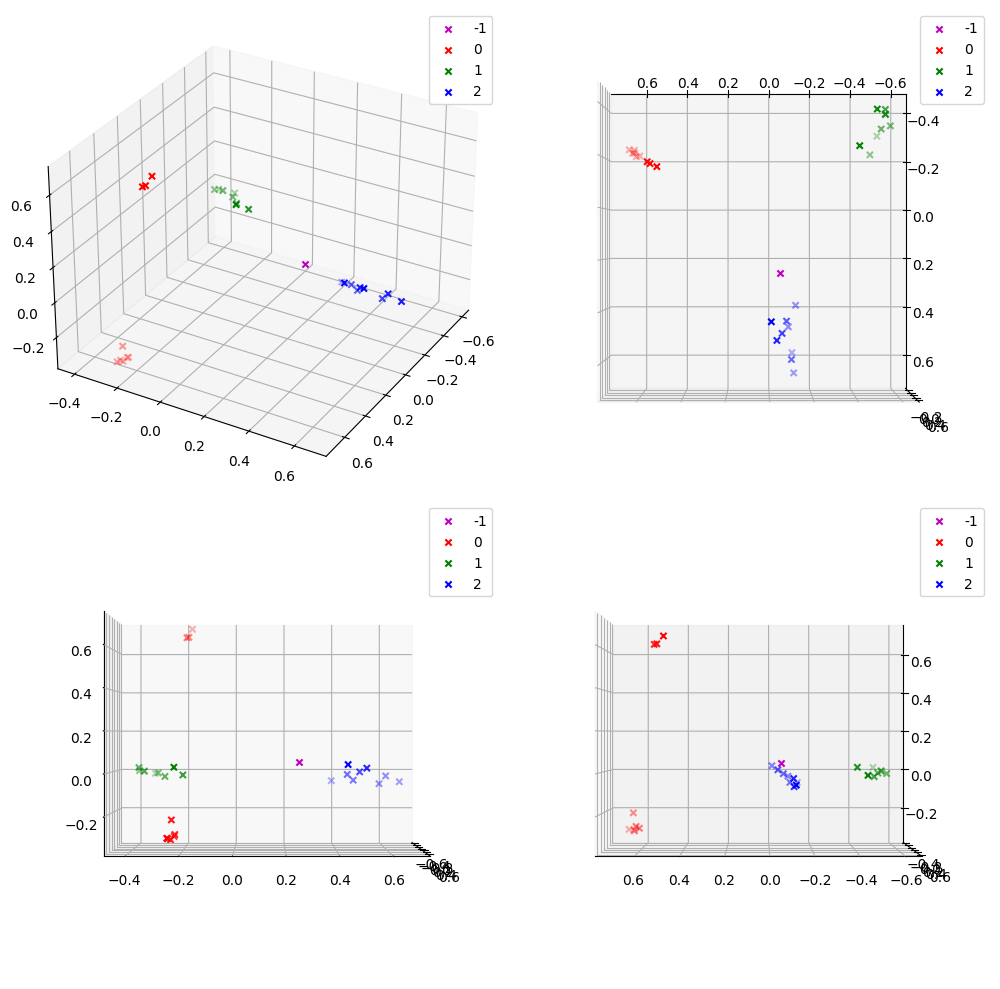

In [34]:
fig = plt.figure(figsize=(10,10))

for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels2):
        ax.scatter(*features_PCA[labels2==label].T, c=colors[label], marker='x', label=label)
        ax.view_init(elev=o[0], azim=o[1])
    ax.legend()

plt.tight_layout()
plt.show()

In [27]:
gm_2 = GaussianMixture(n_components=2, n_init=10)
gm_3 = GaussianMixture(n_components=3, n_init=10)
gm_4 = GaussianMixture(n_components=4, n_init=10)

labels_2 = gm_2.fit_predict(features_PCA)
labels_3 = gm_3.fit_predict(features_PCA)
labels_4 = gm_4.fit_predict(features_PCA)

probs_2 = gm_2.predict_proba(features_PCA)
probs_3 = gm_3.predict_proba(features_PCA)
probs_4 = gm_4.predict_proba(features_PCA)


In [35]:
def valid_labels(counts):
    if (
        (MAX_OUTLIERS < counts) & (counts < min(NUM_PIECES))
    ).any(): 
        return False
    return True

def count_outliers(count_label):
    for num_pieces in NUM_PIECES_INVERSE:
        if count_label-num_pieces>=0:
            return count_label-num_pieces

NUM_PIECES_INVERSE = [16,12,9]
NUM_CLUSTER_INVERSE = [4,3,2]

def classify_simple(features_PCA):
    for i in NUM_CLUSTER_INVERSE:
        gm = GaussianMixture(n_components=i, n_init=10,init_params='k-means++')
        labels = gm.fit_predict(features_PCA.copy())
        counts, _= np.histogram(labels, bins=len(np.unique(labels)))
        if valid_labels(counts):
            for label in np.unique(labels) :
                cluster_samples=features_PCA[labels==label]
                if len(cluster_samples) not in NUM_PIECES:
                    num_outliers = count_outliers(counts[label])
                    proba = gm.score_samples(cluster_samples)
                    outliers_index = np.argsort(proba)[:num_outliers]
                    new_labels = label * np.ones(len(cluster_samples))
                    new_labels[outliers_index] = -1
                    labels[labels == label] = new_labels
                    
            return labels

labels = classify_simple(features_PCA)